In [4]:
from s2flow.data import datasets
import os

os.chdir('/home/dhester/s2flow')

In [58]:
config = {
    'data': {
        "samples_par_path": "./data/cpb_lc/samples.par",
        "data_dir_path": "./data/cpb_lc",
        "augmentations": "spatial",
        "num_workers": 4,
        "pin_memory": True,
        "source_data": "s2sr",
        "fold": 0,
    }
}
train_dataloader, val_dataloader = datasets.get_lc_dataloaders(config)

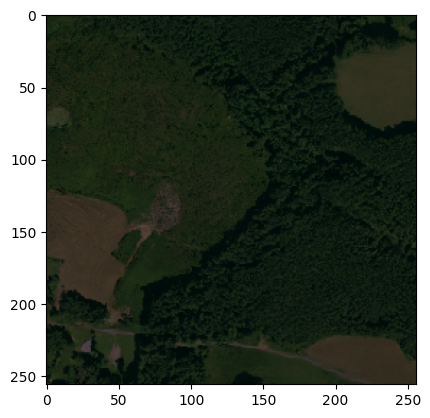

In [59]:
sample = next(iter(train_dataloader))



import matplotlib.pyplot as plt
plt.imshow(sample[0][0, :3, :, :].permute(1, 2, 0) * 3)  # Show band 4
# sample[0]

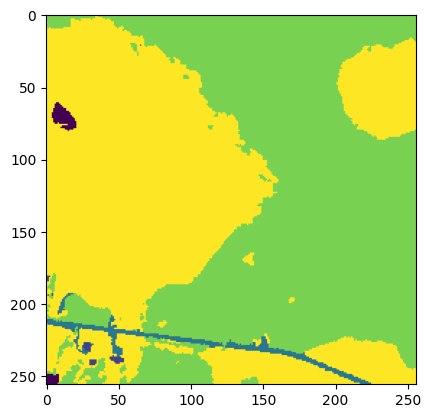

In [60]:
plt.imshow(sample[1][0, :, :])

In [62]:
import geopandas as gpd
samples_gdf = gpd.read_parquet("./data/cpb_lc/samples_fullscheme.par")
samples_gdf['s2sr_path'] = samples_gdf['s2_path'].str.replace('sentinel2', 'sentinel2_sr')

In [64]:
samples_gdf.to_parquet("./data/cpb_lc/samples_fullscheme.par")

In [71]:
import rasterio as rio

with rio.open('data/cpb_lc/landcover_fullscheme/00000.tif') as src:
    data = src.read()

In [76]:
data

array([[[22, 37, 37, ...,  6,  6,  6],
        [37, 37, 37, ...,  6,  6,  6],
        [43, 43, 37, ...,  6,  6,  6],
        ...,
        [ 6,  6,  6, ...,  6,  6,  6],
        [ 6,  6,  6, ...,  6,  6,  6],
        [ 6,  6,  6, ...,  6,  6,  6]]], shape=(1, 256, 256), dtype=uint8)

In [7]:
import torch
import torch.nn as nn
import yaml
from s2flow.engine.training import LandCoverTrainer
from s2flow.models import get_lc_model
from pathlib import Path
import os

os.chdir('/home/dhester/s2flow')

config = yaml.safe_load(open('configs/s2flow-lctrain_class_determination.yaml', 'r'))

job_name = config.get('job', {}).get('name', None)
if job_name is None:
    raise ValueError("Job name must be specified in the config under 'job.name'")

log_path = Path(config.get('job', {}).get('log_dir', './logs'))
log_path = log_path / job_name
log_path.mkdir(parents=True, exist_ok=True)

# copy config file to log directory for reference
# copy2(config_path, log_path / 'config.yaml')

out_path = Path(config.get('job', {}).get('out_dir', './runs'))
out_path = out_path / job_name
out_path.mkdir(parents=True, exist_ok=True)

config['paths'] = {
    'log_path': log_path,
    'out_path': out_path
}

model = get_lc_model(config)

trainer = LandCoverTrainer.from_checkpoint(config, model)

In [10]:
torch.save(trainer.model.state_dict(), out_path / 'model.pt')

OrderedDict([('total_ops', tensor([0.], device='cuda:0', dtype=torch.float64)),
             ('total_params',
              tensor([0.], device='cuda:0', dtype=torch.float64)),
             ('encoder.total_ops',
              tensor([0.], device='cuda:0', dtype=torch.float64)),
             ('encoder.total_params',
              tensor([0.], device='cuda:0', dtype=torch.float64)),
             ('encoder.patch_embed1.total_ops',
              tensor([0.], device='cuda:0', dtype=torch.float64)),
             ('encoder.patch_embed1.total_params',
              tensor([0.], device='cuda:0', dtype=torch.float64)),
             ('encoder.patch_embed1.proj.weight',
              tensor([[[[ 2.7732e-05, -5.7690e-04,  5.4347e-03,  ...,  6.8100e-03,
                         -2.3131e-03,  6.7272e-03],
                        [ 2.0063e-04,  1.2660e-02,  2.2591e-02,  ...,  8.6340e-03,
                          1.4056e-02,  1.7165e-02],
                        [ 9.1319e-03,  2.5847e-02,  7.0273e-03,